In [1]:
package_paths = [
    '../input/pytorch-image-models/pytorch-image-models-master', #'../input/efficientnet-pytorch-07/efficientnet_pytorch-0.7.0'
    '../input/image-fmix/FMix-master'
]
import sys; 

for pth in package_paths:
    sys.path.append(pth)
    
from fmix import sample_mask, make_low_freq_image, binarise_mask

In [2]:
from glob import glob
from sklearn.model_selection import GroupKFold, StratifiedKFold
import cv2
from skimage import io
import torch
from torch import nn
import os
from datetime import datetime
import time
import random
import cv2
import torchvision
from torchvision import transforms
import pandas as pd
import numpy as np
from tqdm import tqdm

import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler
from torch.cuda.amp import autocast, GradScaler
from torch.nn.modules.loss import _WeightedLoss
import torch.nn.functional as F

import timm

import sklearn
import warnings
import joblib
from sklearn.metrics import roc_auc_score, log_loss
from sklearn import metrics
import warnings
import cv2
import pydicom
#from efficientnet_pytorch import EfficientNet
from scipy.ndimage.interpolation import zoom

In [3]:
CFG = {
    'fold_num': 5,
    'seed': 719,
    'model_arch': 'tf_efficientnet_b4_ns',
    'img_size': 512,
    'epochs': 15,
    'train_bs': 16,
    'valid_bs': 32,
    'T_0': 10,
    'lr': 1e-4,
    'min_lr': 1e-6,
    'weight_decay':1e-6,
    'num_workers': 4,
    'accum_iter': 2, # suppoprt to do batch accumulation for backprop with effectively larger batch size
    'verbose_step': 1,
    'device': 'cuda:0'
}

In [4]:
train = pd.read_csv('../input/cassava-leaf-disease-classification/train.csv')
train.head()

image_id  label
0  1000015157.jpg      0
1  1000201771.jpg      3
2   100042118.jpg      1
3  1000723321.jpg      1
4  1000812911.jpg      3

In [5]:
train.label.value_counts()

3    13158
4     2577
2     2386
1     2189
0     1087
Name: label, dtype: int64

> We could do stratified validation split in each fold to make each fold's train and validation set looks like the whole train set in target distributions.

In [6]:
submission = pd.read_csv('../input/cassava-leaf-disease-classification/sample_submission.csv')
submission.head()

image_id  label
0  2216849948.jpg      4

# Helper Functions

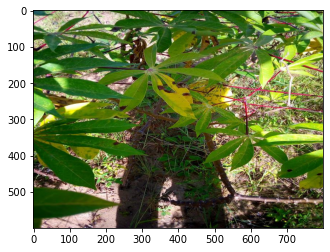

In [7]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
def get_img(path):
    im_bgr = cv2.imread(path)
    im_rgb = im_bgr[:, :, ::-1]
    #print(im_rgb)
    return im_rgb

img = get_img('../input/cassava-leaf-disease-classification/train_images/1000015157.jpg')
plt.imshow(img)
plt.show()

# Dataset

In [8]:
def rand_bbox(size, lam):
    W = size[0]
    H = size[1]
    cut_rat = np.sqrt(1. - lam)
    cut_w = np.int(W * cut_rat)
    cut_h = np.int(H * cut_rat)

    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)
    return bbx1, bby1, bbx2, bby2


class CassavaDataset(Dataset):
    def __init__(self, df, data_root, 
                 transforms=None, 
                 output_label=True, 
                 one_hot_label=False,
                 do_fmix=False, 
                 fmix_params={
                     'alpha': 1., 
                     'decay_power': 3., 
                     'shape': (CFG['img_size'], CFG['img_size']),
                     'max_soft': True, 
                     'reformulate': False
                 },
                 do_cutmix=False,
                 cutmix_params={
                     'alpha': 1,
                 }
                ):
        
        super().__init__()
        self.df = df.reset_index(drop=True).copy()
        self.transforms = transforms
        self.data_root = data_root
        self.do_fmix = do_fmix
        self.fmix_params = fmix_params
        self.do_cutmix = do_cutmix
        self.cutmix_params = cutmix_params
        
        self.output_label = output_label
        self.one_hot_label = one_hot_label
        
        if output_label == True:
            self.labels = self.df['label'].values
            #print(self.labels)
            
            if one_hot_label is True:
                self.labels = np.eye(self.df['label'].max()+1)[self.labels]
                #print(self.labels)
            
    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, index: int):
        
        # get labels
        if self.output_label:
            target = self.labels[index]
          
        img  = get_img("{}/{}".format(self.data_root, self.df.loc[index]['image_id']))

        if self.transforms:
            img = self.transforms(image=img)['image']
        
        if self.do_fmix and np.random.uniform(0., 1., size=1)[0] > 0.5:
            with torch.no_grad():
                #lam, mask = sample_mask(**self.fmix_params)
                
                lam = np.clip(np.random.beta(self.fmix_params['alpha'], self.fmix_params['alpha']),0.6,0.7)
                
                # Make mask, get mean / std
                mask = make_low_freq_image(self.fmix_params['decay_power'], self.fmix_params['shape'])
                mask = binarise_mask(mask, lam, self.fmix_params['shape'], self.fmix_params['max_soft'])
    
                fmix_ix = np.random.choice(self.df.index, size=1)[0]
                fmix_img  = get_img("{}/{}".format(self.data_root, self.df.iloc[fmix_ix]['image_id']))

                if self.transforms:
                    fmix_img = self.transforms(image=fmix_img)['image']

                mask_torch = torch.from_numpy(mask)
                
                # mix image
                img = mask_torch*img+(1.-mask_torch)*fmix_img

                #print(mask.shape)

                #assert self.output_label==True and self.one_hot_label==True

                # mix target
                rate = mask.sum()/CFG['img_size']/CFG['img_size']
                target = rate*target + (1.-rate)*self.labels[fmix_ix]
                #print(target, mask, img)
                #assert False
        
        if self.do_cutmix and np.random.uniform(0., 1., size=1)[0] > 0.5:
            #print(img.sum(), img.shape)
            with torch.no_grad():
                cmix_ix = np.random.choice(self.df.index, size=1)[0]
                cmix_img  = get_img("{}/{}".format(self.data_root, self.df.iloc[cmix_ix]['image_id']))
                if self.transforms:
                    cmix_img = self.transforms(image=cmix_img)['image']
                    
                lam = np.clip(np.random.beta(self.cutmix_params['alpha'], self.cutmix_params['alpha']),0.3,0.4)
                bbx1, bby1, bbx2, bby2 = rand_bbox((CFG['img_size'], CFG['img_size']), lam)

                img[:, bbx1:bbx2, bby1:bby2] = cmix_img[:, bbx1:bbx2, bby1:bby2]

                rate = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (CFG['img_size'] * CFG['img_size']))
                target = rate*target + (1.-rate)*self.labels[cmix_ix]
                
            #print('-', img.sum())
            #print(target)
            #assert False
                            
        # do label smoothing
        #print(type(img), type(target))
        if self.output_label == True:
            return img, target
        else:
            return img

# Define Train\Validation Image Augmentations

In [9]:
from albumentations import (
    HorizontalFlip, VerticalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine, RandomResizedCrop,
    IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose, Normalize, Cutout, CoarseDropout, ShiftScaleRotate, CenterCrop, Resize
)

from albumentations.pytorch import ToTensorV2

def get_train_transforms():
    return Compose([
            RandomResizedCrop(CFG['img_size'], CFG['img_size']),
            Transpose(p=0.5),
            HorizontalFlip(p=0.5),
            VerticalFlip(p=0.5),
            ShiftScaleRotate(p=0.5),
            HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.5),
            RandomBrightnessContrast(brightness_limit=(-0.1,0.1), contrast_limit=(-0.1, 0.1), p=0.5),
            Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0, p=1.0),
            CoarseDropout(p=0.5),
            Cutout(p=0.5),
            ToTensorV2(p=1.0),
        ], p=1.)
  
        
def get_valid_transforms():
    return Compose([
            CenterCrop(CFG['img_size'], CFG['img_size'], p=1.),
            Resize(CFG['img_size'], CFG['img_size']),
            Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0, p=1.0),
            ToTensorV2(p=1.0),
        ], p=1.)

# Model

In [10]:
class CassvaImgClassifier(nn.Module):
    def __init__(self, model_arch, n_class, pretrained=False):
        super().__init__()
        self.model = timm.create_model(model_arch, pretrained=pretrained)
        n_features = self.model.classifier.in_features
        self.model.classifier = nn.Linear(n_features, n_class)
        '''
        self.model.classifier = nn.Sequential(
            nn.Dropout(0.3),
            #nn.Linear(n_features, hidden_size,bias=True), nn.ELU(),
            nn.Linear(n_features, n_class, bias=True)
        )
        '''
    def forward(self, x):
        x = self.model(x)
        return x

# Tempered logloss
- git: https://github.com/mlpanda/bi-tempered-loss-pytorch

- usage

```
t1, t2 = 0.8, 1.2
for epoch in range(epochs):
  for x, y in train_loader:
  ...
  loss = bi_tempered_logistic_loss(model(x), y, t1, t2)
  loss.backward()
  optimizer.step()
  optimizer.zero_grad()
```

In [11]:
def log_t(u, t):
    """Compute log_t for `u'."""
    if t==1.0:
        return u.log()
    else:
        return (u.pow(1.0 - t) - 1.0) / (1.0 - t)

def exp_t(u, t):
    """Compute exp_t for `u'."""
    if t==1:
        return u.exp()
    else:
        return (1.0 + (1.0-t)*u).relu().pow(1.0 / (1.0 - t))

def compute_normalization_fixed_point(activations, t, num_iters):

    """Returns the normalization value for each example (t > 1.0).
    Args:
      activations: A multi-dimensional tensor with last dimension `num_classes`.
      t: Temperature 2 (> 1.0 for tail heaviness).
      num_iters: Number of iterations to run the method.
    Return: A tensor of same shape as activation with the last dimension being 1.
    """
    mu, _ = torch.max(activations, -1, keepdim=True)
    normalized_activations_step_0 = activations - mu

    normalized_activations = normalized_activations_step_0

    for _ in range(num_iters):
        logt_partition = torch.sum(
                exp_t(normalized_activations, t), -1, keepdim=True)
        normalized_activations = normalized_activations_step_0 * \
                logt_partition.pow(1.0-t)

    logt_partition = torch.sum(
            exp_t(normalized_activations, t), -1, keepdim=True)
    normalization_constants = - log_t(1.0 / logt_partition, t) + mu

    return normalization_constants

def compute_normalization_binary_search(activations, t, num_iters):

    """Returns the normalization value for each example (t < 1.0).
    Args:
      activations: A multi-dimensional tensor with last dimension `num_classes`.
      t: Temperature 2 (< 1.0 for finite support).
      num_iters: Number of iterations to run the method.
    Return: A tensor of same rank as activation with the last dimension being 1.
    """

    mu, _ = torch.max(activations, -1, keepdim=True)
    normalized_activations = activations - mu

    effective_dim = \
        torch.sum(
                (normalized_activations > -1.0 / (1.0-t)).to(torch.int32),
            dim=-1, keepdim=True).to(activations.dtype)

    shape_partition = activations.shape[:-1] + (1,)
    lower = torch.zeros(shape_partition, dtype=activations.dtype, device=activations.device)
    upper = -log_t(1.0/effective_dim, t) * torch.ones_like(lower)

    for _ in range(num_iters):
        logt_partition = (upper + lower)/2.0
        sum_probs = torch.sum(
                exp_t(normalized_activations - logt_partition, t),
                dim=-1, keepdim=True)
        update = (sum_probs < 1.0).to(activations.dtype)
        lower = torch.reshape(
                lower * update + (1.0-update) * logt_partition,
                shape_partition)
        upper = torch.reshape(
                upper * (1.0 - update) + update * logt_partition,
                shape_partition)

    logt_partition = (upper + lower)/2.0
    return logt_partition + mu

class ComputeNormalization(torch.autograd.Function):
    """
    Class implementing custom backward pass for compute_normalization. See compute_normalization.
    """
    @staticmethod
    def forward(ctx, activations, t, num_iters):
        if t < 1.0:
            normalization_constants = compute_normalization_binary_search(activations, t, num_iters)
        else:
            normalization_constants = compute_normalization_fixed_point(activations, t, num_iters)

        ctx.save_for_backward(activations, normalization_constants)
        ctx.t=t
        return normalization_constants

    @staticmethod
    def backward(ctx, grad_output):
        activations, normalization_constants = ctx.saved_tensors
        t = ctx.t
        normalized_activations = activations - normalization_constants 
        probabilities = exp_t(normalized_activations, t)
        escorts = probabilities.pow(t)
        escorts = escorts / escorts.sum(dim=-1, keepdim=True)
        grad_input = escorts * grad_output
        
        return grad_input, None, None

def compute_normalization(activations, t, num_iters=5):
    """Returns the normalization value for each example. 
    Backward pass is implemented.
    Args:
      activations: A multi-dimensional tensor with last dimension `num_classes`.
      t: Temperature 2 (> 1.0 for tail heaviness, < 1.0 for finite support).
      num_iters: Number of iterations to run the method.
    Return: A tensor of same rank as activation with the last dimension being 1.
    """
    return ComputeNormalization.apply(activations, t, num_iters)

def tempered_sigmoid(activations, t, num_iters = 5):
    """Tempered sigmoid function.
    Args:
      activations: Activations for the positive class for binary classification.
      t: Temperature tensor > 0.0.
      num_iters: Number of iterations to run the method.
    Returns:
      A probabilities tensor.
    """
    internal_activations = torch.stack([activations,
        torch.zeros_like(activations)],
        dim=-1)
    internal_probabilities = tempered_softmax(internal_activations, t, num_iters)
    return internal_probabilities[..., 0]


def tempered_softmax(activations, t, num_iters=5):
    """Tempered softmax function.
    Args:
      activations: A multi-dimensional tensor with last dimension `num_classes`.
      t: Temperature > 1.0.
      num_iters: Number of iterations to run the method.
    Returns:
      A probabilities tensor.
    """
    if t == 1.0:
        return activations.softmax(dim=-1)

    normalization_constants = compute_normalization(activations, t, num_iters)
    return exp_t(activations - normalization_constants, t)

def bi_tempered_binary_logistic_loss(activations,
        labels,
        t1,
        t2,
        label_smoothing = 0.0,
        num_iters=5,
        reduction='mean'):

    """Bi-Tempered binary logistic loss.
    Args:
      activations: A tensor containing activations for class 1.
      labels: A tensor with shape as activations, containing probabilities for class 1
      t1: Temperature 1 (< 1.0 for boundedness).
      t2: Temperature 2 (> 1.0 for tail heaviness, < 1.0 for finite support).
      label_smoothing: Label smoothing
      num_iters: Number of iterations to run the method.
    Returns:
      A loss tensor.
    """
    internal_activations = torch.stack([activations,
        torch.zeros_like(activations)],
        dim=-1)
    internal_labels = torch.stack([labels.to(activations.dtype),
        1.0 - labels.to(activations.dtype)],
        dim=-1)
    return bi_tempered_logistic_loss(internal_activations, 
            internal_labels,
            t1,
            t2,
            label_smoothing = label_smoothing,
            num_iters = num_iters,
            reduction = reduction)

def bi_tempered_logistic_loss(activations,
        labels,
        t1,
        t2,
        label_smoothing=0.0,
        num_iters=5,
        reduction = 'mean'):

    """Bi-Tempered Logistic Loss.
    Args:
      activations: A multi-dimensional tensor with last dimension `num_classes`.
      labels: A tensor with shape and dtype as activations (onehot), 
        or a long tensor of one dimension less than activations (pytorch standard)
      t1: Temperature 1 (< 1.0 for boundedness).
      t2: Temperature 2 (> 1.0 for tail heaviness, < 1.0 for finite support).
      label_smoothing: Label smoothing parameter between [0, 1). Default 0.0.
      num_iters: Number of iterations to run the method. Default 5.
      reduction: ``'none'`` | ``'mean'`` | ``'sum'``. Default ``'mean'``.
        ``'none'``: No reduction is applied, return shape is shape of
        activations without the last dimension.
        ``'mean'``: Loss is averaged over minibatch. Return shape (1,)
        ``'sum'``: Loss is summed over minibatch. Return shape (1,)
    Returns:
      A loss tensor.
    """

    if len(labels.shape)<len(activations.shape): #not one-hot
        labels_onehot = torch.zeros_like(activations)
        labels_onehot.scatter_(1, labels[..., None], 1)
    else:
        labels_onehot = labels

    if label_smoothing > 0:
        num_classes = labels_onehot.shape[-1]
        labels_onehot = ( 1 - label_smoothing * num_classes / (num_classes - 1) ) \
                * labels_onehot + \
                label_smoothing / (num_classes - 1)

    probabilities = tempered_softmax(activations, t2, num_iters)

    loss_values = labels_onehot * log_t(labels_onehot + 1e-10, t1) \
            - labels_onehot * log_t(probabilities, t1) \
            - labels_onehot.pow(2.0 - t1) / (2.0 - t1) \
            + probabilities.pow(2.0 - t1) / (2.0 - t1)
    loss_values = loss_values.sum(dim = -1) #sum over classes

    if reduction == 'none':
        return loss_values
    if reduction == 'sum':
        return loss_values.sum()
    if reduction == 'mean':
        return loss_values.mean()

# SAM optimizer
- git: https://github.com/davda54/sam
- usage

```
...

model = YourModel()
base_optimizer = torch.optim.SGD  # define an optimizer for the "sharpness-aware" update
optimizer = SAM(model.parameters(), base_optimizer, lr=0.1, momentum=0.9)
...

for input, output in data:

  # first forward-backward pass
  loss = loss_function(output, model(input))  # use this loss for any training statistics
  loss.backward()
  optimizer.first_step(zero_grad=True)

  # second forward-backward pass
  loss_function(output, model(input)).backward()
  optimizer.second_step(zero_grad=True)

```

In [12]:
class SAM(torch.optim.Optimizer):
    def __init__(self, params, base_optimizer, rho=0.05, **kwargs):
        assert rho >= 0.0, f"Invalid rho, should be non-negative: {rho}"

        defaults = dict(rho=rho, **kwargs)
        super(SAM, self).__init__(params, defaults)

        self.base_optimizer = base_optimizer(self.param_groups, **kwargs)
        self.param_groups = self.base_optimizer.param_groups

    @torch.no_grad()
    def first_step(self, zero_grad=False):
        grad_norm = self._grad_norm()
        for group in self.param_groups:
            scale = group["rho"] / (grad_norm + 1e-12)

            for p in group["params"]:
                if p.grad is None: continue
                e_w = p.grad * scale.to(p)
                p.add_(e_w)  # climb to the local maximum "w + e(w)"
                self.state[p]["e_w"] = e_w

        if zero_grad: self.zero_grad()

    @torch.no_grad()
    def second_step(self, zero_grad=False):
        for group in self.param_groups:
            for p in group["params"]:
                if p.grad is None: continue
                p.sub_(self.state[p]["e_w"])  # get back to "w" from "w + e(w)"

        self.base_optimizer.step()  # do the actual "sharpness-aware" update

        if zero_grad: self.zero_grad()

    def step(self, closure=None):
        raise NotImplementedError("SAM doesn't work like the other optimizers, you should first call `first_step` and the `second_step`; see the documentation for more info.")

    def _grad_norm(self):
        shared_device = self.param_groups[0]["params"][0].device  # put everything on the same device, in case of model parallelism
        norm = torch.norm(
                    torch.stack([
                        p.grad.norm(p=2).to(shared_device)
                        for group in self.param_groups for p in group["params"]
                        if p.grad is not None
                    ]),
                    p=2
               )
        return norm

# Training APIs

In [13]:
def prepare_dataloader(df, trn_idx, val_idx, data_root='../input/cassava-leaf-disease-classification/train_images/'):
    
    from catalyst.data.sampler import BalanceClassSampler
    
    train_ = df.loc[trn_idx,:].reset_index(drop=True)
    valid_ = df.loc[val_idx,:].reset_index(drop=True)
        
    train_ds = CassavaDataset(train_, data_root, transforms=get_train_transforms(), output_label=True, one_hot_label=True, do_fmix=False, do_cutmix=False)
    valid_ds = CassavaDataset(valid_, data_root, transforms=get_valid_transforms(), output_label=True, one_hot_label=True)
    
    train_loader = torch.utils.data.DataLoader(
        train_ds,
        batch_size=CFG['train_bs'],
        pin_memory=False,
        drop_last=False,
        shuffle=True,        
        num_workers=CFG['num_workers'],
        #sampler=BalanceClassSampler(labels=train_['label'].values, mode="downsampling")
    )
    val_loader = torch.utils.data.DataLoader(
        valid_ds, 
        batch_size=CFG['valid_bs'],
        num_workers=CFG['num_workers'],
        shuffle=False,
        pin_memory=False,
    )
    return train_loader, val_loader

def train_one_epoch(epoch, model, loss_fn, optimizer, train_loader, device, scheduler=None, schd_batch_update=False):
    model.train()

    t = time.time()
    running_loss = None

    pbar = tqdm(enumerate(train_loader), total=len(train_loader))
    for step, (imgs, image_labels) in pbar:
        imgs = imgs.to(device).float()
        image_labels = image_labels.to(device).long()

        #print(image_labels.shape, exam_label.shape)
        with autocast():
            image_preds = model(imgs)   #output = model(input)
            #print(image_preds.shape, exam_pred.shape)

#             loss = loss_fn(image_preds, image_labels)
            loss = bi_tempered_binary_logistic_loss(image_preds,image_labels,t1=0.9,t2=1.05,label_smoothing=0.001)
            
            scaler.scale(loss).backward()

            if running_loss is None:
                running_loss = loss.item()
            else:
                running_loss = running_loss * .99 + loss.item() * .01

            if ((step + 1) %  CFG['accum_iter'] == 0) or ((step + 1) == len(train_loader)):
                # may unscale_ here if desired (e.g., to allow clipping unscaled gradients)

                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad() 
                
                if scheduler is not None and schd_batch_update:
                    scheduler.step()

            if ((step + 1) % CFG['verbose_step'] == 0) or ((step + 1) == len(train_loader)):
                description = f'epoch {epoch} loss: {running_loss:.4f}'
                
                pbar.set_description(description)
                
    if scheduler is not None and not schd_batch_update:
        scheduler.step()
        
    return running_loss
        
def valid_one_epoch(epoch, model, loss_fn, val_loader, device, scheduler=None, schd_loss_update=False):
    model.eval()

    t = time.time()
    loss_sum = 0
    sample_num = 0
    image_preds_all = []
    image_targets_all = []
    
    pbar = tqdm(enumerate(val_loader), total=len(val_loader))
    for step, (imgs, image_labels) in pbar:
        imgs = imgs.to(device).float()
        image_labels = image_labels.to(device).long() #onehot
        
        image_preds = model(imgs)   #output = model(input)
        #print(image_preds.shape, exam_pred.shape)
        image_preds_all += [torch.argmax(image_preds, 1).detach().cpu().numpy()]
        image_targets_all += [torch.argmax(image_labels, 1).detach().cpu().numpy()]
        
        loss = loss_fn(image_preds, image_labels)
        
        loss_sum += loss.item()*image_labels.shape[0]
        sample_num += image_labels.shape[0]  
        running_loss = loss_sum/sample_num
        
        if ((step + 1) % CFG['verbose_step'] == 0) or ((step + 1) == len(val_loader)):
            description = f'epoch {epoch} loss: {running_loss:.4f}'
            pbar.set_description(description)
    
    image_preds_all = np.concatenate(image_preds_all)
    image_targets_all = np.concatenate(image_targets_all)
    acc = (image_preds_all==image_targets_all).mean()
    print('validation multi-class accuracy = {:.4f}'.format(acc))
    
    if scheduler is not None:
        if schd_loss_update:
            scheduler.step(loss_sum/sample_num)
        else:
            scheduler.step()
    
    return running_loss, acc

# Loss func

In [14]:
import torch
from torch.nn.modules.loss import _WeightedLoss
import torch.nn.functional as F
from torch.autograd import Variable

class SmoothBCEwLogits(_WeightedLoss):
    def __init__(self, weight=None, reduction='mean', smoothing=0.0):
        super().__init__(weight=weight, reduction=reduction)
        self.smoothing = smoothing
        self.weight = weight
        self.reduction = reduction

    @staticmethod
    def _smooth(targets:torch.Tensor, n_labels:int, smoothing=0.0):
       
        assert 0 <= smoothing < 1
        with torch.no_grad():
            targets = targets * (1.0 - smoothing) + 0.5 * smoothing
        return targets

    def forward(self, inputs, targets):
        inputs = F.log_softmax(inputs, -1)
        targets = SmoothBCEwLogits._smooth(targets, inputs.size(-1),
            self.smoothing)
        loss = F.binary_cross_entropy_with_logits(inputs, targets,self.weight)

        if  self.reduction == 'sum':
            loss = loss.sum()
        elif  self.reduction == 'mean':
            loss = loss.mean()

        return loss

In [15]:
# reference: https://www.kaggle.com/c/siim-isic-melanoma-classification/discussion/173733
class MyCrossEntropyLoss(_WeightedLoss):
    def __init__(self, weight=None, reduction='mean'):
        super().__init__(weight=weight, reduction=reduction)
        self.weight = weight
        self.reduction = reduction

    def forward(self, inputs, targets):
        lsm = F.log_softmax(inputs, -1)

        if self.weight is not None:
            lsm = lsm * self.weight.unsqueeze(0)

        loss = -(targets * lsm).sum(-1)

        if  self.reduction == 'sum':
            loss = loss.sum()
        elif  self.reduction == 'mean':
            loss = loss.mean()

        return loss

# Main Loop

In [ ]:
import pickle

if __name__ == '__main__':
     # for training only, need nightly build pytorch

    seed_everything(CFG['seed'])
    
    folds = StratifiedKFold(n_splits=CFG['fold_num'], shuffle=True, random_state=CFG['seed']).split(np.arange(train.shape[0]), train.label.values)
    
    for fold, (trn_idx, val_idx) in enumerate(folds):
        # we'll train fold 0 first
#         if fold > 0:
#             break 
        loss_hist_tr = []
        loss_hist_val = []
        acc_hist_val = []
        print('Training with {} started'.format(fold))
        
        print(len(trn_idx), len(val_idx))
        train_loader, val_loader = prepare_dataloader(train, trn_idx, val_idx, data_root='../input/cassava-leaf-disease-classification/train_images/')

        device = torch.device(CFG['device'])
        
        model = CassvaImgClassifier(CFG['model_arch'], train.label.nunique(), pretrained=True).to(device)
        scaler = GradScaler()   
        optimizer = torch.optim.Adam(model.parameters(), lr=CFG['lr'], weight_decay=CFG['weight_decay'])
#         base_optimizer = torch.optim.SGD  # define an optimizer for the "sharpness-aware" update
#         optimizer = SAM(model.parameters(), base_optimizer, lr=CFG['lr'], momentum=0.9)
        #scheduler = torch.optim.lr_scheduler.StepLR(optimizer, gamma=0.1, step_size=CFG['epochs']-1)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=CFG['T_0'], T_mult=1, eta_min=CFG['min_lr'], last_epoch=-1)
        #scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer=optimizer, pct_start=0.1, div_factor=25, 
        #                                                max_lr=CFG['lr'], epochs=CFG['epochs'], steps_per_epoch=len(train_loader))
        
        loss_tr = SmoothBCEwLogits(smoothing=0.001).to(device) #label smoothing
#         loss_tr = bi_tempered_binary_logistic_loss
        loss_fn = SmoothBCEwLogits(smoothing=0.0).to(device)
        
        best_acc = 0
        for epoch in range(CFG['epochs']):
            train_loss = train_one_epoch(epoch, model, loss_tr, optimizer, train_loader, device, scheduler=scheduler, schd_batch_update=False)
            loss_hist_tr.append(train_loss)
            with torch.no_grad():
                valid_loss, valid_acc = valid_one_epoch(epoch, model, loss_fn, 
                                                        val_loader, device, scheduler=None,
                                                        schd_loss_update=False)
                loss_hist_val.append(valid_loss)
                acc_hist_val.append(valid_acc)
            
            if valid_acc > best_acc:
                print('saving best_weights...')
                torch.save(model.state_dict(),'{}_fold_{}_best.pth'.format(CFG['model_arch'], fold))
                best_acc=valid_acc
        
        save_files = {f'loss_hist_tr_{fold}.pkl': loss_hist_tr,
                      f'loss_hist_val_{fold}.pkl': loss_hist_val,
                      f'acc_hist_val_{fold}.pkl': acc_hist_val}
        for key in save_files:
            with open(key, 'wb') as f:
                pickle.dump(save_files[key], f)
        #torch.save(model.cnn_model.state_dict(),'{}/cnn_model_fold_{}_{}'.format(CFG['model_path'], fold, CFG['tag']))
        del model, optimizer, train_loader, val_loader, scaler, scheduler
        torch.cuda.empty_cache()

Training with 0 started
17117 4280


epoch 0 loss: 0.2316: 100%|██████████| 134/134 [01:12<00:00,  1.86it/s]


validation multi-class accuracy = 0.8766
saving best_weights...


epoch 1 loss: 0.2241: 100%|██████████| 134/134 [01:10<00:00,  1.90it/s]


validation multi-class accuracy = 0.8827
saving best_weights...


epoch 2 loss: 0.2242: 100%|██████████| 134/134 [01:12<00:00,  1.86it/s]


validation multi-class accuracy = 0.8860
saving best_weights...


epoch 3 loss: 0.2359: 100%|██████████| 134/134 [01:11<00:00,  1.88it/s]

validation multi-class accuracy = 0.8778



epoch 4 loss: 0.2256: 100%|██████████| 134/134 [01:12<00:00,  1.84it/s]


validation multi-class accuracy = 0.8956
saving best_weights...


epoch 5 loss: 0.2332: 100%|██████████| 134/134 [01:12<00:00,  1.85it/s]

validation multi-class accuracy = 0.8902



epoch 6 loss: 0.2265: 100%|██████████| 134/134 [01:12<00:00,  1.85it/s]

validation multi-class accuracy = 0.8911



epoch 7 loss: 0.2306: 100%|██████████| 134/134 [01:11<00:00,  1.87it/s]

validation multi-class accuracy = 0.8916



epoch 8 loss: 0.2284: 100%|██████████| 134/134 [01:12<00:00,  1.86it/s]

validation multi-class accuracy = 0.8886



epoch 9 loss: 0.2302: 100%|██████████| 134/134 [01:10<00:00,  1.90it/s]

validation multi-class accuracy = 0.8909



epoch 10 loss: 0.2327: 100%|██████████| 134/134 [01:09<00:00,  1.92it/s]

validation multi-class accuracy = 0.8916



epoch 11 loss: 0.2309: 100%|██████████| 134/134 [01:10<00:00,  1.90it/s]

validation multi-class accuracy = 0.8904



epoch 12 loss: 0.2394: 100%|██████████| 134/134 [01:10<00:00,  1.90it/s]

validation multi-class accuracy = 0.8874



epoch 13 loss: 0.2437: 100%|██████████| 134/134 [01:10<00:00,  1.90it/s]

validation multi-class accuracy = 0.8843



epoch 14 loss: 0.2519: 100%|██████████| 134/134 [01:10<00:00,  1.90it/s]


validation multi-class accuracy = 0.8822
Training with 1 started
17117 4280


epoch 0 loss: 0.2377: 100%|██████████| 134/134 [01:10<00:00,  1.89it/s]


validation multi-class accuracy = 0.8666
saving best_weights...


epoch 1 loss: 0.2365: 100%|██████████| 134/134 [01:10<00:00,  1.90it/s]


validation multi-class accuracy = 0.8881
saving best_weights...


epoch 2 loss: 0.2235: 100%|██████████| 134/134 [01:12<00:00,  1.84it/s]

validation multi-class accuracy = 0.8881



epoch 3 loss: 0.2286: 100%|██████████| 134/134 [01:13<00:00,  1.83it/s]


validation multi-class accuracy = 0.8904
saving best_weights...


epoch 4 loss: 0.2279: 100%|██████████| 134/134 [01:10<00:00,  1.90it/s]


validation multi-class accuracy = 0.8918
saving best_weights...


epoch 5 loss: 0.2330: 100%|██████████| 134/134 [01:10<00:00,  1.91it/s]


validation multi-class accuracy = 0.8949
saving best_weights...


epoch 6 loss: 0.2331: 100%|██████████| 134/134 [01:10<00:00,  1.91it/s]

validation multi-class accuracy = 0.8904



epoch 7 loss: 0.2362: 100%|██████████| 134/134 [01:10<00:00,  1.91it/s]

validation multi-class accuracy = 0.8871



epoch 8 loss: 0.2376: 100%|██████████| 134/134 [01:10<00:00,  1.91it/s]

validation multi-class accuracy = 0.8886



epoch 9 loss: 0.2370: 100%|██████████| 134/134 [01:12<00:00,  1.84it/s]

validation multi-class accuracy = 0.8932



epoch 10 loss: 0.2387: 100%|██████████| 134/134 [01:13<00:00,  1.83it/s]

validation multi-class accuracy = 0.8818



epoch 11 loss: 0.2444: 100%|██████████| 134/134 [01:13<00:00,  1.83it/s]

validation multi-class accuracy = 0.8792



epoch 12 loss: 0.2482: 100%|██████████| 134/134 [01:11<00:00,  1.88it/s]

validation multi-class accuracy = 0.8752



epoch 13 loss: 0.2459: 100%|██████████| 134/134 [01:10<00:00,  1.91it/s]

validation multi-class accuracy = 0.8857



epoch 14 loss: 0.2522: 100%|██████████| 134/134 [01:10<00:00,  1.89it/s]


validation multi-class accuracy = 0.8869
Training with 2 started
17118 4279


epoch 0 loss: 0.2359: 100%|██████████| 134/134 [01:11<00:00,  1.88it/s]


validation multi-class accuracy = 0.8712
saving best_weights...


epoch 1 loss: 0.2289: 100%|██████████| 134/134 [01:10<00:00,  1.91it/s]


validation multi-class accuracy = 0.8799
saving best_weights...


epoch 2 loss: 0.2284: 100%|██████████| 134/134 [01:10<00:00,  1.91it/s]


validation multi-class accuracy = 0.8902
saving best_weights...


epoch 3 loss: 0.2324: 100%|██████████| 134/134 [01:09<00:00,  1.93it/s]


validation multi-class accuracy = 0.8906
saving best_weights...


epoch 4 loss: 0.2321: 100%|██████████| 134/134 [01:09<00:00,  1.92it/s]

validation multi-class accuracy = 0.8789



epoch 5 loss: 0.2332: 100%|██████████| 134/134 [01:10<00:00,  1.91it/s]

validation multi-class accuracy = 0.8871



epoch 6 loss: 0.2295: 100%|██████████| 134/134 [01:10<00:00,  1.91it/s]

validation multi-class accuracy = 0.8888



epoch 7 loss: 0.2324: 100%|██████████| 134/134 [01:09<00:00,  1.93it/s]

validation multi-class accuracy = 0.8904



epoch 8 loss: 0.2352: 100%|██████████| 134/134 [01:10<00:00,  1.91it/s]

validation multi-class accuracy = 0.8904



epoch 9 loss: 0.2354: 100%|██████████| 134/134 [01:11<00:00,  1.88it/s]

validation multi-class accuracy = 0.8888



epoch 10 loss: 0.2378: 100%|██████████| 134/134 [01:12<00:00,  1.85it/s]

validation multi-class accuracy = 0.8806



epoch 11 loss: 0.2417: 100%|██████████| 134/134 [01:10<00:00,  1.91it/s]

validation multi-class accuracy = 0.8810



epoch 12 loss: 0.2397: 100%|██████████| 134/134 [01:10<00:00,  1.90it/s]

validation multi-class accuracy = 0.8815



epoch 13 loss: 0.2474: 100%|██████████| 134/134 [01:11<00:00,  1.87it/s]

validation multi-class accuracy = 0.8806



epoch 14 loss: 0.2426: 100%|██████████| 134/134 [01:11<00:00,  1.87it/s]


validation multi-class accuracy = 0.8881
Training with 3 started
17118 4279


epoch 0 loss: 0.2311: 100%|██████████| 134/134 [01:11<00:00,  1.86it/s]


validation multi-class accuracy = 0.8661
saving best_weights...


epoch 1 loss: 0.2262: 100%|██████████| 134/134 [01:12<00:00,  1.85it/s]


validation multi-class accuracy = 0.8862
saving best_weights...


epoch 2 loss: 0.2259: 100%|██████████| 134/134 [01:11<00:00,  1.86it/s]

validation multi-class accuracy = 0.8855



epoch 3 loss: 0.2312: 100%|██████████| 134/134 [01:11<00:00,  1.88it/s]

validation multi-class accuracy = 0.8857



epoch 4 loss: 0.2288: 100%|██████████| 134/134 [01:10<00:00,  1.90it/s]


validation multi-class accuracy = 0.8944
saving best_weights...


epoch 5 loss: 0.2259: 100%|██████████| 134/134 [01:10<00:00,  1.89it/s]

validation multi-class accuracy = 0.8934



epoch 6 loss: 0.2286: 100%|██████████| 134/134 [01:11<00:00,  1.87it/s]

validation multi-class accuracy = 0.8925



epoch 7 loss: 0.2343: 100%|██████████| 134/134 [01:09<00:00,  1.92it/s]

validation multi-class accuracy = 0.8918



epoch 8 loss: 0.2321: 100%|██████████| 134/134 [01:10<00:00,  1.91it/s]

validation multi-class accuracy = 0.8925



epoch 9 loss: 0.2326: 100%|██████████| 134/134 [01:10<00:00,  1.91it/s]

validation multi-class accuracy = 0.8904



epoch 10 loss: 0.2309: 100%|██████████| 134/134 [01:09<00:00,  1.92it/s]

validation multi-class accuracy = 0.8899



epoch 11 loss: 0.2470: 100%|██████████| 134/134 [01:09<00:00,  1.92it/s]

validation multi-class accuracy = 0.8768



epoch 12 loss: 0.2380: 100%|██████████| 134/134 [01:09<00:00,  1.92it/s]

validation multi-class accuracy = 0.8881



epoch 13 loss: 0.2436: 100%|██████████| 134/134 [01:10<00:00,  1.91it/s]

validation multi-class accuracy = 0.8808



epoch 14 loss: 0.2494: 100%|██████████| 134/134 [01:09<00:00,  1.92it/s]


validation multi-class accuracy = 0.8841
Training with 4 started
17118 4279


epoch 0 loss: 0.2287: 100%|██████████| 134/134 [01:09<00:00,  1.91it/s]


validation multi-class accuracy = 0.8829
saving best_weights...


epoch 1 loss: 0.2288: 100%|██████████| 134/134 [01:09<00:00,  1.93it/s]


validation multi-class accuracy = 0.8843
saving best_weights...


epoch 2 loss: 0.2318: 100%|██████████| 134/134 [01:09<00:00,  1.92it/s]

validation multi-class accuracy = 0.8796



epoch 3 loss: 0.2287: 100%|██████████| 134/134 [01:09<00:00,  1.92it/s]


validation multi-class accuracy = 0.8965
saving best_weights...


epoch 4 loss: 0.1016:  18%|█▊        | 192/1070 [02:46<12:38,  1.16it/s]

# Inferece part is here: https://www.kaggle.com/khyeh0719/pytorch-efficientnet-baseline-inference-tta